# Packages

In [1]:
# Loading and presenting data related
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
from sklearn.metrics import confusion_matrix

# Model related
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim

# Get rid of warnings
import warnings
warnings.filterwarnings('ignore')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rc('font', **font)

# Data loading Functions

In [2]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

class XY(object):
    def __init__(self, X_files, Y_files, folder, index_file, L, verbose = True):
        
        self.X_files = X_files
        self.Y_files = Y_files
        self.L = L
        self.folder = folder
        self.verbose = verbose
        self.indexes = self.ReadIndex(index_file)
        self.X_out, self.Y_out = self.BalanceRead()
        
    def shape(self):
        return self.X_out.shape[1:]
    
    def __len__(self):
        return len(self.X_out)
    
    def ReadIndex(self, index_file):
        ifile = open(index_file, 'r').read().split('\n')[:-1]
        index = {}
        for i in range(len(ifile)):
            idx = [ifile[i].split()[0], int(ifile[i].split()[1])]
            if idx[0] in index:
                index[idx[0]].append(idx[1])
            else:
                index[idx[0]] = [idx[1]]
        return index
    
    def BalanceRead(self):
        X_out = []
        Y_out = []
        for i in range(len(self.X_files)):
            if self.X_files[i][8+len(self.folder):-4] in self.indexes:
                f = open(self.X_files[i],'r').read().split('\n')[2:-1]
                Y = open(self.Y_files[i],'r').read().split('\n')[2:]
                for idx in self.indexes[X_files[i][8+len(self.folder):-4]]:
                    config = f[idx].split()
                    config = [[(int(spin)+1)/2, 1-(int(spin)+1)/2] for spin in config]
                    config = [[config[i * self.L + j] for j in range(self.L)] for i in range(self.L)]
                    X_out.append(config)
                    Y_out.append([float(Y[idx])/100, 1-float(Y[idx])/100])
        X_out = torch.tensor(X_out).float()
        Y_out = torch.tensor(Y_out).float()
        return X_out, Y_out
    
    def PlotDataHisto(self):
        plt.hist(self.Y[:,0], bins = 33, alpha = 0.5, density = True, label = r'before balance, $N_{data}$ = %d'%self.Y.shape[0] )
        plt.hist(self.Y_out[:,0], bins = 33, alpha = 0.5, density = True, label = r'after balance, $N_{data}$ = %d'%self.Y_out.shape[0])
        plt.legend(loc = 'best')
        plt.xlabel(r'$p_n$')
        plt.ylabel('probability density')
        plt.title('Data Balancing')
        plt.show()

# CNN

In [3]:
class CNN(nn.Module):
    def __init__(self, input_length, num_layers, num_kernels, kernel_size, dropout_rate = 0.1):
        super(CNN, self).__init__()
        self.input_length = input_length
        self.num_layers = num_layers
        self.num_kernels = [2] + num_kernels
        self.conv = []
        self.dim_after_conv = self.input_length
        for i in range(self.num_layers):
            self.conv.append(nn.Conv2d(self.num_kernels[i], self.num_kernels[i+1], kernel_size))
            self.dim_after_conv = (self.dim_after_conv - kernel_size + 1)//2
        self.conv = nn.ModuleList(self.conv)
        self.dropout = nn.Dropout(p = dropout_rate)
        self.linear1 = nn.Linear(self.dim_after_conv ** 2 * num_kernels[-1], 10)
        self.linear2 = nn.Linear(10, 2)
    
    def forward(self, x):
        for i in range(self.num_layers):
            x = F.max_pool2d(F.relu(self.conv[i](x)), 2)
            x = self.dropout(x)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.linear1(x))
        x = F.softmax(self.linear2(x))
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

class Dataset(Dataset):
    def __init__(self, X, Y):
        self.X = X.permute(0,3,1,2).float()
        self.Y = Y.float()
        self.len = X.shape[0]
    def __getitem__(self, index):
        return self.X[index], self.Y[index]
    def __len__(self):
        return self.len

# Logistic Regression

In [9]:
def ConvertTo1D(X):
    X = np.asarray(X)
    return torch.tensor([x[:,:,0].flatten() for x in X]).float()

class Dataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
        self.len = X.shape[0]
    def __getitem__(self, index):
        return self.X[index], self.Y[index]
    def __len__(self):
        return self.len

class LogReg(nn.Module):
    def __init__(self, input_len):
        super(LogReg, self).__init__()
        self.input_len = input_len
        self.linear = torch.nn.Linear(self.input_len, 2)
        
    def forward(self, x):
        x = F.softmax(self.linear(x))
        return x

# Train/Test funcitons

In [6]:
def Train(model, train_dataset, val_dataset, model_save_path,
          verbose = 1, EPOCHES = 10, lr = 0.001,
          mmt = 0.9, batch_size = 32, patience = 10):
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    
    loss_fn = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=mmt)
    patient = 0
    hist_val_loss = []
    for epoch in range(EPOCHES):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            if verbose == 1:
                print('[Epoch %d], [Batch %d/%d]'%(epoch+1, i+1, len(train_dataset)//batch_size), end = '\r')
        
        _, __, val_loss = Test(model, val_dataset, batch_size)
        
        is_better = len(hist_val_loss)==0 or val_loss < min(hist_val_loss)
        
        hist_val_loss.append(val_loss)
                            
        print('\n[Epoch %d]Training loss: %.3f, Val loss: %.3f' %(epoch + 1, running_loss / i, val_loss), end = ' ')

        if is_better:
            patient = 0
            print('save currently the best model to [%s]' % model_save_path)
            torch.save(model.state_dict(), model_save_path)

        elif patient < patience:
            patient += 1
            print('hit patience %d' % patient)
            if patient == patience:
                print('early stop!')
                break 
                
    return model

def Test(model, test_dataset, batch_size):
    
    testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    
    loss_fn = nn.BCELoss()
    
    Y_true = []
    Y_pre = []
    with torch.no_grad():
        running_loss = 0.0
        j = 0
        for i, data in enumerate(testloader, 0):
            j += 1
            inputs, labels = data
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()
            Y_true.append(labels)
            Y_pre.append(outputs)
        average_loss = running_loss/j
    
    Y_true = torch.cat(Y_true, 0)
    Y_pre = torch.cat(Y_pre, 0)
    return Y_true, Y_pre, average_loss

def VisualizePerformance(Y_true, Y_pre, loss, label, title, model = 'CNN', alpha = 0.1, txtpos = [0.5,0.2]):
    plt.scatter(Y_true[:,0], Y_pre[:,0], marker = 'o', alpha = alpha, color = color, label = label + ' ' + model)
    plt.text(txtpos[0], txtpos[1], label +' test loss: %.3f'%loss)
    leg = plt.legend(loc = 'upper left')
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
    plt.xlabel(r'$Y_{true}$')
    plt.ylabel(r'$Y_{pre}$')
    plt.plot([0,1],[0,1], color = 'red')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.title(title)

# Running CNN

In [69]:
folders = ['NearestNeighborData', 'R=3Data', 'R=5Data', 'R=10Data']
index_files = [folders[i] + '/indexes.txt' for i in range(len(folders))]
labels = ['R=1', 'R=3', 'R=5', 'R=10']
text = [[0.5, 0.2],[], [], [0.5,0.1]]
Ls = [10, 30, 100, 100]
files= [[0,3], [2,9], [1,200], [1, 62]]
k_size = [3, 5, 5, 5]
uniform_init = 0.1
for j in range(4):
    L = Ls[j]
    print(folders[j][:-4])
    X_files = [folders[j] + '/config_'+str(i)+'.txt' for i in range(files[j][0],files[j][1])]
    Y_files = [folders[j] + '/interv_'+str(i)+'.txt' for i in range(files[j][0],files[j][1])]
    data = XY(X_files, Y_files, folders[j], index_files[j], L, verbose = False)
    print(data.X_out.shape)
    X_train, Y_train = data.X_out[:int(len(data) * 0.8)], data.Y_out[:int(len(data) * 0.8)]
    X_val, Y_val = data.X_out[int(len(data) * 0.8):int(len(data) * 0.9)], data.Y_out[int(len(data) * 0.8):int(len(data) * 0.9)]
    X_test, Y_test = data.X_out[int(len(data) * 0.9):], data.Y_out[int(len(data) * 0.9):]
    train_dataset = Dataset(X_train, Y_train)
    test_dataset = Dataset(X_test, Y_test)
    val_dataset = Dataset(X_val, Y_val)
    model = CNN(input_length = L, num_layers =  2, num_kernels = [8,16], kernel_size = k_size[j])
    
    for p in model.parameters():
        p.data.uniform_(-uniform_init, uniform_init)
            
    trained_model = Train(model, train_dataset, val_dataset, labels[j]+'_model.bin', EPOCHES = 100, verbose = 0)
    Y_true, Y_pre, CEloss = Test(trained_net, test_dataset, batch_size = 32)
    print('Test loss:' + str(CEloss))
#    if j == 0 or j == 3:
#        VisualizePerformance(Y_true, Y_pre, CEloss, label = labels[j], title = 'CNN performance', alpha = 0.1, txtpos = text[j])
#plt.show()

NearestNeighbor
torch.Size([14593, 10, 10, 2])

[Epoch 1]Training loss: 0.695, Val loss: 0.693 save currently the best model to [R=1_model.bin]

[Epoch 2]Training loss: 0.695, Val loss: 0.693 save currently the best model to [R=1_model.bin]

[Epoch 3]Training loss: 0.695, Val loss: 0.693 save currently the best model to [R=1_model.bin]

[Epoch 4]Training loss: 0.695, Val loss: 0.693 save currently the best model to [R=1_model.bin]

[Epoch 5]Training loss: 0.695, Val loss: 0.693 save currently the best model to [R=1_model.bin]

[Epoch 6]Training loss: 0.695, Val loss: 0.693 save currently the best model to [R=1_model.bin]

[Epoch 7]Training loss: 0.694, Val loss: 0.692 save currently the best model to [R=1_model.bin]

[Epoch 8]Training loss: 0.694, Val loss: 0.692 save currently the best model to [R=1_model.bin]

[Epoch 9]Training loss: 0.694, Val loss: 0.692 save currently the best model to [R=1_model.bin]

[Epoch 10]Training loss: 0.693, Val loss: 0.691 save currently the best model t

KeyboardInterrupt: 

In [91]:
L =10
folder = 'NearestNeighborData'
file = [0,3]
index_file = 'NearestNeighborData//indexes.txt'
label = 'R=1'
uniform_init = 0.1
min_val_losses = []
print(folder[:-4])
X_files = [folder + '/config_'+str(i)+'.txt' for i in range(file[0],file[1])]
Y_files = [folder + '/interv_'+str(i)+'.txt' for i in range(file[0],file[1])]
data = XY(X_files, Y_files, folder, index_file, L, verbose = False)
print(data.X_out.shape)
#perform cross validation

file = open('R=1Loss.txt', 'w+')
for i in range(10):
    bounds = [0, int(len(data) * i * 0.1), int(len(data) * (i+1) * 0.1), len(data)]
    print(bounds)
    X_val, Y_val = ConvertTo1D(data.X_out[bounds[1]:bounds[2]]), data.Y_out[bounds[1]:bounds[2]]
    
    X_train = torch.cat((ConvertTo1D(data.X_out[bounds[0]:bounds[1]]), ConvertTo1D(data.X_out[bounds[2]:bounds[3]])), dim=0)
    Y_train = torch.cat((data.Y_out[bounds[0]:bounds[1]], data.Y_out[bounds[2]:bounds[3]]), dim=0)
    
    train_dataset = Dataset(X_train, Y_train)
    val_dataset = Dataset(X_val, Y_val)
    model = LogReg(input_len = L*L)

    for p in model.parameters():
        p.data.uniform_(-uniform_init, uniform_init)

    min_val_loss = Train(model, train_dataset, val_dataset, label+'_model'+str(i)+'.bin', EPOCHES = 10, verbose = 0)
    min_val_losses.append(min_val_loss)
    file.write(str(min_val_loss) + '\n')
file.write('mean: ' + str(np.mean(min_val_losses)) + '\n')
file.write('stdev: ' + str(np.std(min_val_losses)) + '\n')
file.close()

NearestNeighbor
torch.Size([14593, 10, 10, 2])
[0, 0, 1459, 14593]

[Epoch 1]Training loss: 0.580, Val loss: 0.528 save currently the best model to [R=1_model0.bin]

[Epoch 2]Training loss: 0.528, Val loss: 0.512 save currently the best model to [R=1_model0.bin]

[Epoch 3]Training loss: 0.520, Val loss: 0.508 save currently the best model to [R=1_model0.bin]

[Epoch 4]Training loss: 0.517, Val loss: 0.506 save currently the best model to [R=1_model0.bin]

[Epoch 5]Training loss: 0.516, Val loss: 0.506 hit patience 1

[Epoch 6]Training loss: 0.515, Val loss: 0.505 save currently the best model to [R=1_model0.bin]

[Epoch 7]Training loss: 0.515, Val loss: 0.505 hit patience 1

[Epoch 8]Training loss: 0.515, Val loss: 0.503 save currently the best model to [R=1_model0.bin]

[Epoch 9]Training loss: 0.514, Val loss: 0.504 hit patience 1

[Epoch 10]Training loss: 0.514, Val loss: 0.503 hit patience 2
[0, 1459, 2918, 14593]

[Epoch 1]Training loss: 0.583, Val loss: 0.536 save currently the be

KeyboardInterrupt: 

# Compare CNN, FeatureLogReg, SpinlogReg in long range Ising Model

In [4]:
L =100
folder = 'R=10Data'
file = [1,62]
index_file = 'R=10Data//indexes.txt'
label = 'R=10'
uniform_init = 0.1
min_val_losses = []
print(folder[:-4])
X_files = [folder + '/config_'+str(i)+'.txt' for i in range(file[0],file[1])]
Y_files = [folder + '/interv_'+str(i)+'.txt' for i in range(file[0],file[1])]
data = XY(X_files, Y_files, folder, index_file, L, verbose = False)
print(data.X_out.shape)

R=10
torch.Size([14422, 100, 100, 2])


0.5186787798352863


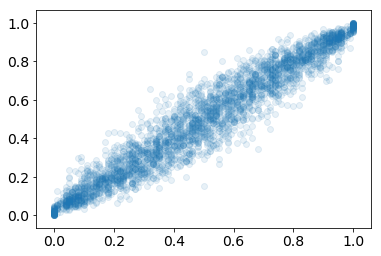

In [7]:
X_test, Y_test = data.X_out[:int(len(data) * 0.1)], data.Y_out[:int(len(data) * 0.1)]
test_dataset = Dataset(X_test, Y_test)
model = CNN(input_length = L, num_layers = 2, num_kernels = [8,16], kernel_size = 5)
model.load_state_dict(torch.load('TrainedModel/R=10_model9.bin', map_location=torch.device('cpu')))
Y_true_CNN, Y_pre_CNN, CEloss = Test(model, test_dataset, batch_size = 32)
plt.scatter(Y_true_CNN, Y_pre_CNN, alpha = 0.1)
print(CEloss)

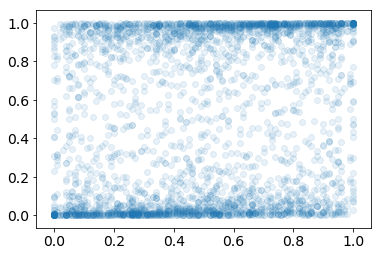

In [10]:
X_test = torch.tensor((ConvertTo1D(data.X_out[:int(len(data) * 0.1)])))
Y_test = torch.tensor(data.Y_out[:int(len(data) * 0.1)])
test_dataset = Dataset(X_test, Y_test)
model = LogReg(input_len = L*L)
model.load_state_dict(torch.load('TrainedModel/R=10_modelLog3.bin', map_location=torch.device('cpu')))
Y_true_Log, Y_pre_Log, CEloss = Test(model, test_dataset, batch_size = 32)
plt.scatter(Y_true_Log, Y_pre_Log, alpha = 0.1)

0.5192013836520559


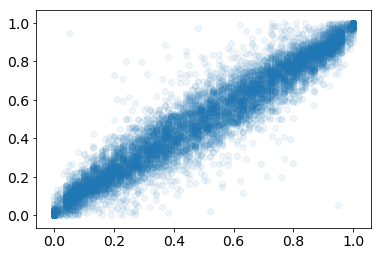

In [11]:
# Geometric Feature
class XY(object):
    def __init__(self, data_file):
        X, Y = self.ReadXY(data_file)
        Y2 = 1-Y
        self.Y = torch.tensor(np.concatenate((Y,Y2), axis = 1)).float()
        self.X = torch.tensor(X).float()
        
    def ReadXY(self, file):
        data = np.loadtxt(file)
        X = data[:,:-1]
        Y = data[:,-1:]
        return X, Y
    
    def shape(self):
        return self.X_out.shape[1:]
    
    def __len__(self):
        return len(self.X)

def Normalize(X):
    X = np.nan_to_num(np.asarray(X))
    norms = np.mean(X, axis = 0)
    stds = np.std(X, axis = 0)
    X = torch.tensor((X-norms)/stds).float()
    return X

class Dataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
        self.len = X.shape[0]
    def __getitem__(self, index):
        return self.X[index], self.Y[index]
    def __len__(self):
        return self.len

num_features = 10
dataF = XY(folder+'/GeoFeature.dat')
Y = dataF.Y
X = Normalize(dataF.X)
X_test, Y_test = X[int(len(dataF)*0.1):int(len(dataF)*0.4)], Y[int(len(dataF)*0.1):int(len(dataF)*0.4)]
test_dataset = Dataset(X_test, Y_test)
model = LogReg(input_len = num_features)
model.load_state_dict(torch.load('TrainedModel/R=10_modelFeature0.bin', map_location=torch.device('cpu')))
Y_true_FLog, Y_pre_FLog, CEloss = Test(model, test_dataset, batch_size = 32)
plt.scatter(Y_true_FLog, Y_pre_FLog, alpha = 0.07)
print(CEloss)

(0, 1)

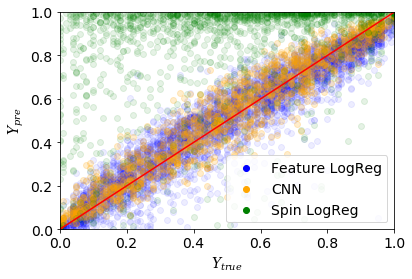

In [13]:
plt.scatter(Y_true_FLog[:,0], Y_pre_FLog[:,0], alpha = 0.07, label = 'Feature LogReg', color = 'blue')
plt.scatter(Y_true_CNN[:,0], Y_pre_CNN[:,0], alpha = 0.2, label = 'CNN', color = 'orange')
plt.scatter(Y_true_Log[:,0], Y_pre_Log[:,0], alpha = 0.1, label = 'Spin LogReg', color = 'green')
leg = plt.legend(loc = 'best')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel(r'$Y_{true}$')
plt.ylabel(r'$Y_{pre}$')
plt.plot([0,1],[0,1], color = 'red')
plt.xlim([0,1])
plt.ylim([0,1])

Following plot compares the prediction power of the three machine learning methods

(0, 1)

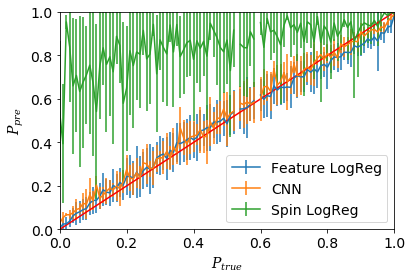

In [14]:
num_bins = 101
result = []
x = [0.01 * i for i in range(101)]
labels = ['Feature LogReg', 'CNN', 'Spin LogReg']
j = 0
for dset in [[Y_true_FLog, Y_pre_FLog],[Y_true_CNN, Y_pre_CNN],[Y_true_Log, Y_pre_Log]]:
    binned = [[] for i in range(num_bins)]
    for i in range(len(dset[0])):
        binned[int(dset[0][i][0] * 100)].append(dset[1][i][0])
    stats = [[np.mean(binned[i]) for i in range(num_bins)], [np.std(binned[i]) for i in range(num_bins)]]
    plt.errorbar(x, stats[0], yerr = stats[1], label = labels[j])
    j += 1
plt.xlabel(r'$P_{true}$')
plt.ylabel(r'$P_{pre}$')
plt.plot([0,1],[0,1], color = 'red')
plt.legend(loc = 'best')
plt.xlim([0,1])
plt.ylim([0,1])

Following plot shows that magnitzation has very week correlation with nucleation probability

Text(0, 0.5, '$p_{nuc}$')

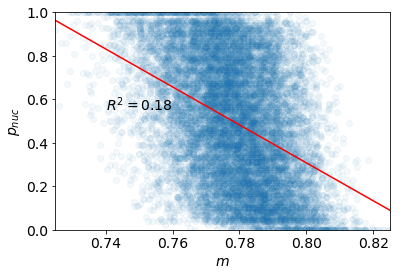

In [33]:
plt.scatter(m, Y, alpha = 0.05)
plt.plot([0, 1], [reg.coef_ * 0 + reg.intercept_, reg.coef_ * 1 + reg.intercept_,], color = 'red')
plt.text(0.74, 0.55, r'$R^2=%.2f$'%reg.score(m, Y))
plt.ylim([0,1])
plt.xlim([0.725, 0.825])
plt.xlabel('$m$')
plt.ylabel('$p_{nuc}$')